In [2]:
## Standard libraries
import os
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\Danny\AppData\Local\Temp\ipykernel_21696\1202862137.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [3]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False)

Seed set to 42


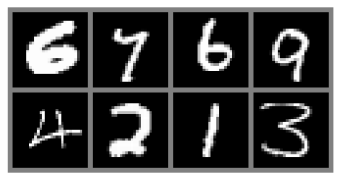

In [4]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [5]:
class MaskedConvolution(nn.Module):
    
    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically 
        kernel_size = (mask.shape[0], mask.shape[1])
        padding = tuple([(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)
        # Mask as buffer => it is no parameter but still a tensor of the module 
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])
        
    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

In [6]:
class VerticalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0
        
        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0
        
        super().__init__(c_in, c_out, mask, **kwargs)

        
class HorizontalStackConvolution(MaskedConvolution):
    
    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0
        
        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0
        
        super().__init__(c_in, c_out, mask, **kwargs)

In [7]:
inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads
    
    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0]) 
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

#show_center_recep_field(inp_img, inp_img)

In [8]:
# Question 1
# Implement a version of the model without the gated convolution and dilation, using several layers of masked convolutions using vertical / horizontal stacks.

class PixelCNN2(pl.LightningModule):
    
    def __init__(self, c_in, c_hidden, layers, mask_starting_conv_center_pixel = True,  mask_other_conv_center_pixel = False):
        super().__init__()
        self.save_hyperparameters()
        
        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=mask_starting_conv_center_pixel, kernel_size=5)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=mask_starting_conv_center_pixel, kernel_size=5)

        # Masked Convolutions
        self.conv_vert = nn.ModuleList([VerticalStackConvolution(c_hidden, c_hidden, kernel_size=3, mask_center=mask_other_conv_center_pixel) for _ in range(layers)])
        self.conv_horiz = nn.ModuleList([HorizontalStackConvolution(c_hidden, c_hidden, kernel_size=3, mask_center=mask_other_conv_center_pixel) for _ in range(layers)])
        
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)
        
        
    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        self.to(x.device)
        x = (x.float() / 255.0) * 2 - 1 
        
        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)

        v_stack, h_stack = F.relu(v_stack), F.relu(h_stack)
        
        # Masked Convolutions
        for conv_v, conv_h in zip(self.conv_vert, self.conv_horiz):
            v_stack, h_stack = conv_v(v_stack), conv_h(h_stack)
            h_stack = h_stack + v_stack
            v_stack, h_stack = F.relu(v_stack), F.relu(h_stack)

        # 1x1 classification convolution
        out = self.conv_out(F.relu(h_stack))
        
        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1] // 256, out.shape[2], out.shape[3])
        return out
    

    def calc_loss(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='mean')
        return nll
        
    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill 
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:]) 
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        loss = self.calc_loss(batch[0])                             
        self.log('train_nll', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.calc_loss(batch[0])
        self.log('val_nll', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self.calc_loss(batch[0])
        self.log('test_nll', loss)
    
        

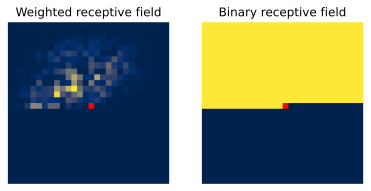

In [9]:
test_model = PixelCNN2(c_in=1, c_hidden=128, layers = 12, mask_starting_conv_center_pixel = True, mask_other_conv_center_pixel = False)
inp = torch.zeros(1,1,28,28)
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [12]:
def train_model(use_pretrained = False, **kwargs):
    logger = TensorBoardLogger("tb_logs", name="my_model")
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN2"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         logger = logger,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_nll"),
                                    LearningRateMonitor("epoch")])
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    #pretrained_filename = os.path.join(CHECKPOINT_PATH, "PixelCNN2.ckpt")
    pretrained_filename = "tb_logs/my_model/version_6/checkpoints/epoch=53-step=21060.ckpt"
    if os.path.isfile(pretrained_filename) and use_pretrained:
        print("Found pretrained model, loading...")
        model = PixelCNN2.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN2(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)
    
    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [13]:
# QUESTION 1 TRAIN
model_q1, result = train_model(c_in=1, c_hidden=128, layers = 12, use_pretrained=True)
test_res = result["test"][0]
print("nll loss: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_nll"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Found pretrained model, loading...


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

nll loss: 0.597


In [14]:
num_params = sum([np.prod(param.shape) for param in model_q1.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 2,399,488


Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

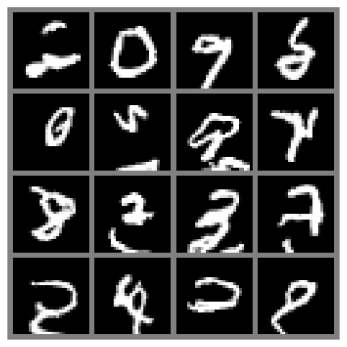

In [15]:
# SAMPLE FROM MODEL QUESTION 1
pl.seed_everything(1)
samples = model_q1.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

Original image and input image to sampling:


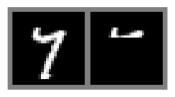

Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


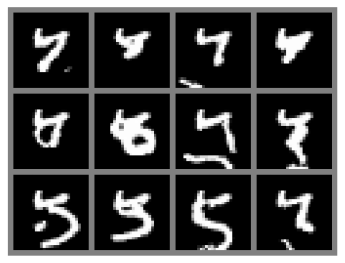

Original image and input image to sampling:


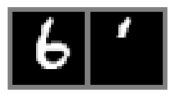

Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


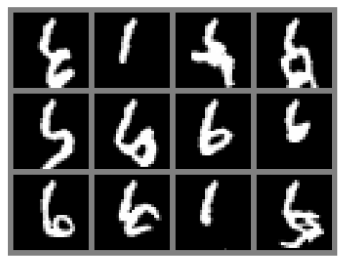

Original image and input image to sampling:


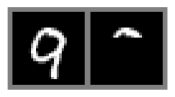

Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

Autocompletion samples:


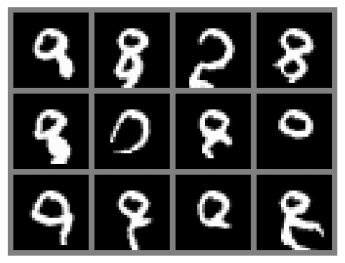

In [16]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,10:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model_q1.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)

for i in range(1,4):
    img = train_set[i][0]
    autocomplete_image(img)

# Question 2

In [17]:
# QUESTION 2
model_q2, result = train_model(c_in=1, c_hidden=128, layers = 12, mask_starting_conv_center_pixel = False, mask_other_conv_center_pixel = False)
test_res = result["test"][0]
print("nll loss: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_nll"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                       | Params
-----------------------------------------------------------
0 | conv_vstack | VerticalStackConvolution   | 3.3 K 
1 | conv_hstack | HorizontalStackConvolution | 768   
2 | conv_vert   | ModuleList                 | 1.8 M 
3 | conv_horiz  | ModuleList                 | 591 K 
4 | conv_out    | Conv2d                     | 33.0 K
-----------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.598     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

nll loss: 0.156


Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

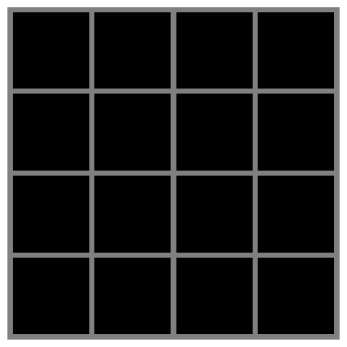

In [19]:
# SAMPLE FROM MODEL QUESTION 2
pl.seed_everything(1)
samples = model_q2.sample(img_shape=(16,1,28,28))
show_imgs(samples.cpu())

# Question 3

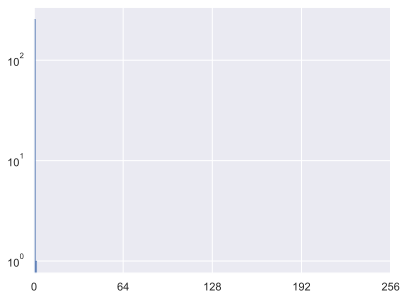

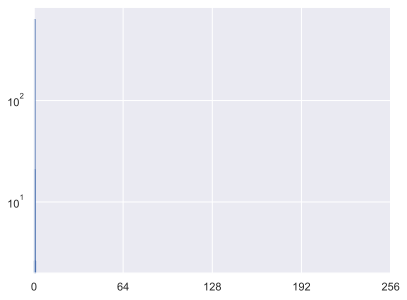

In [20]:
# A) The marginal probability of the first pixel.
# B) The marginal probability of the pixel at position (14,14).
def marginal_prob_of_pixel(pixel):
    det_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False)
    imgs,_ = next(iter(det_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        out = model_q1(imgs)
        out = out[:,:,:,pixel[0],pixel[1]] # pixel at x,y
        out = F.softmax(out, dim=1)
        mean_out = out.mean(dim=[0]).cpu().numpy() # mean over batch

    sns.set()
    plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
    plt.hist(mean_out, bins=256, density=True, **plot_args)
    plt.yscale("log")
    plt.xticks([0,64,128,192,256])
    plt.show()
    plt.close()

marginal_prob_of_pixel((0,0))
marginal_prob_of_pixel((14,14))


[[0.3825328 ]
 [0.00043726]
 [0.00092231]
 [0.00111001]
 [0.00095673]
 [0.00112791]
 [0.00119794]
 [0.00101841]
 [0.00105529]
 [0.00094478]
 [0.00090341]
 [0.00187091]
 [0.00081135]
 [0.0011688 ]
 [0.0008786 ]
 [0.00080062]
 [0.00098745]
 [0.0007422 ]
 [0.00081623]
 [0.00137953]
 [0.00079307]
 [0.0016074 ]
 [0.00080078]
 [0.00074476]
 [0.00109471]
 [0.00096536]
 [0.00087736]
 [0.00104704]
 [0.00083431]
 [0.00163866]
 [0.00085139]
 [0.00125778]
 [0.00205664]
 [0.0006491 ]
 [0.00085638]
 [0.00093177]
 [0.00132825]
 [0.00125701]
 [0.00158044]
 [0.00109605]
 [0.00106236]
 [0.00105671]
 [0.0012882 ]
 [0.00092337]
 [0.00097811]
 [0.00142194]
 [0.00118884]
 [0.00127584]
 [0.00102532]
 [0.00087498]
 [0.00688219]
 [0.00116219]
 [0.00087043]
 [0.00117653]
 [0.00112526]
 [0.00101089]
 [0.00113642]
 [0.00162415]
 [0.00092452]
 [0.00103592]
 [0.00096517]
 [0.00098154]
 [0.00115118]
 [0.00134392]
 [0.00099644]
 [0.00095457]
 [0.00085938]
 [0.00112227]
 [0.00098762]
 [0.00086596]
 [0.00130777]
 [0.00

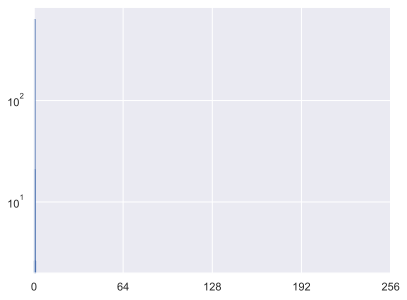

In [21]:
# c
det_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False)
imgs,_ = next(iter(det_loader))
imgs = imgs.to(device)
with torch.no_grad():
    out = model_q1(imgs)
    out = out[:,:,:,out.shape[3]//2,out.shape[4]//2]
    out = F.softmax(out, dim=1)
    mean_out_c = out.mean(dim=[0]).cpu().numpy()
    #mean_out_c = mean_out_c.reshape(-1)
    out = out.cpu().numpy()
    #sum = mean_out[0] + mean_out[1]
   

sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
print(mean_out_c, "Probabilitie for the first pixel")
plt.hist(mean_out_c, bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()



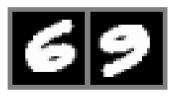

[[4.3146390e-01]
 [4.2690718e-04]
 [1.0619813e-03]
 [1.6646096e-03]
 [1.2879972e-03]
 [1.6306131e-03]
 [1.4999213e-03]
 [1.3466971e-03]
 [2.0572220e-03]
 [1.6488206e-03]
 [1.5700024e-03]
 [1.6427021e-03]
 [1.5916412e-03]
 [1.4270351e-03]
 [1.6362292e-03]
 [1.3164717e-03]
 [1.4461720e-03]
 [1.3872841e-03]
 [1.3104469e-03]
 [1.1904156e-03]
 [1.1761225e-03]
 [1.6031160e-03]
 [1.0949627e-03]
 [1.0003411e-03]
 [1.1679642e-03]
 [1.1182899e-03]
 [1.0502742e-03]
 [9.4551616e-04]
 [1.6287348e-03]
 [1.1850747e-03]
 [9.0590317e-04]
 [1.1847271e-03]
 [1.2083149e-03]
 [5.8867282e-04]
 [9.5770916e-04]
 [7.3095027e-04]
 [1.7999151e-03]
 [9.1285678e-04]
 [9.7362156e-04]
 [1.1873980e-03]
 [1.1344971e-03]
 [1.8134981e-03]
 [1.0170615e-03]
 [8.1822666e-04]
 [9.0660417e-04]
 [8.3555403e-04]
 [1.3059739e-03]
 [9.4442605e-04]
 [8.6817477e-04]
 [8.3448249e-04]
 [1.0650418e-03]
 [1.4515668e-03]
 [7.4209552e-04]
 [8.1358873e-04]
 [1.0139742e-03]
 [7.7676045e-04]
 [8.8432420e-04]
 [1.0204560e-03]
 [7.6970598e-0

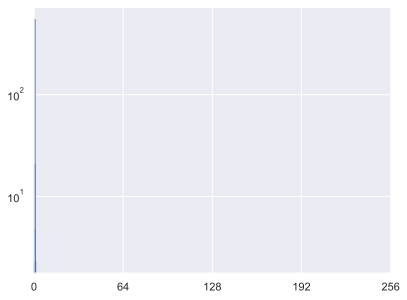

In [22]:
# d) The conditional probability of the middle pixel, given the values of all pixels below and to the right of it.
# We flip the image and calculate the probability of the middle pixel given the pixels above and to the left of it. 
det_loader = data.DataLoader(train_set, batch_size=128, shuffle=False, drop_last=False)
imgs,_ = next(iter(det_loader))
imgs = imgs.to(device)
flipped_imgs = torch.flip(imgs, [2,3])
show_imgs([imgs[0],flipped_imgs[0]])
    
with torch.no_grad():
    out = model_q1(flipped_imgs)
    out = out[:,:,:,out.shape[3]//2,out.shape[4]//2]
    out = F.softmax(out, dim=1)
    mean_out_c = out.mean(dim=[0]).cpu().numpy()
    #mean_out_c = mean_out_c.reshape(-1)
    out = out.cpu().numpy()
    print(mean_out_c, "Probabilitie")
   

sns.set()
plot_args = {"color": to_rgb("C0")+(0.5,), "edgecolor": "C0", "linewidth": 0.5, "width": 1.0}
print(mean_out_c, "Probabilitie for the first pixel")
plt.hist(mean_out_c, bins=256, density=True, **plot_args)
plt.yscale("log")
plt.xticks([0,64,128,192,256])
plt.show()
plt.close()



In [ ]:
# e approximate

# Autoregressive Image Modeling - Exercise 4.
### Daniel Aibinder 318239639, Yonathan Dovgolevsky 327709648

## Question 1
- **Description:** Implement a version of the model without gated convolution and dilation, using several layers of masked convolutions.
### Results
- **Training, Validation , Test Plots for negative log likelihoods:**
  <img src="plots/q1/q1_train_plot.png" alt="Training Loss" width="1000"/>
  <img src="plots/q1/q1_val_plot.png" alt="Validation Loss" width="1000"/>
  <img src="plots/q1/q1_test_plot.png" alt="Test Loss" width="1000"/>
- **Model Samples:**
  <br/>
  <img src="plots/q1/q1_samples.png" alt="Model Samples" width="500"/>

## Question 2
- **Description:** Show what happens if the convolutions are not causal.
### Results
- **Training, Validation, Test Plots:**
<br/>
  <img src="plots/q2/q2_train_plot.png" alt="Training Loss (Non-Causal)" width="1000"/>
  <img src="plots/q2/q2_val_plot.png" alt="Validation Loss (Non-Causal)" width="1000"/>
  <img src="plots/q2/q2_test_plot.png" alt="Test Loss (Non-Causal)" width="1000"/>
- **Model Samples:**
<br/>
<img src="plots/q2/q2_samples.png" alt="Model Samples (Non-Causal)" width="500"/>

## Question 3

### Distributions and Sampling
- **Description:** Compute distributions.

#### a) Marginal Probability of the First Pixel
- **Results:**
  ![Marginal Probability of First Pixel](path_to_marginal_first_pixel.png)

#### b) Marginal Probability of the Middle Pixel (pixel 14, 14)
- **Results:**
  ![Marginal Probability of Middle Pixel](path_to_marginal_middle_pixel.png)

#### c) Conditional Probability of the Middle Pixel, given the values of all pixels above and to the left of it
- **Results:**
  ![Conditional Probability (above and left)](path_to_conditional_above_left.png)

#### d) Conditional Probability of the Middle Pixel, given the values of all pixels below and to the right of it
- **Results:**
  ![Conditional Probability (below and right)](path_to_conditional_below_right.png)

#### e) Conditional Probability of the Middle Pixel, given the values of all other pixels in the image
- **Results:**
  ![Conditional Probability (all pixels)](path_to_conditional_all_pixels.png)

#### f) Samples of the bottom half of an image, given the top half of an image
- **Results:**
  ![Samples (bottom half)](path_to_samples_bottom_half.png)

#### g) Samples of the top half of an image, given the bottom half of an image
- **Results:**
  ![Samples (top half)](path_to_samples_top_half.png)

